# Injury Modelling

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
import matplotlib.pyplot as plt
import pystan
%matplotlib inline
import scipy.stats as stats
import pickle
import us
import vincent
vincent.core.initialize_notebook()

The aim of this section is to model the number of injuries and fatalities caused by a tornado, given that we know its F scale strength and the counties it traverses.

## Population Density

Population density is an important variable in our injury modelling - we want to estimate the population density in the area that each tornado traversed. First, we load in the tornado data, with the warning annotations added in a previous section.

In [2]:
torndata = pd.read_csv('1950-2014_torn.warnings.csv', header=None)
torndata.columns = ['om', 'yr', 'mo', 'dy', 'date', 'time', 'tz', 'st', 'stf', 'stn', 'f', 'inj', 'fat', 'loss', 'closs', 'slat', 'slon', 'elat', 'elon', 'len', 'wid', 'ns', 'sn', 'sg', 'f1', 'f2', 'f3', 'f4', 'touchdown', 'has_warning', 'has_watch', 'warning_time']
torndata.head()

,om,yr,mo,dy,date,time,tz,st,stf,stn,f,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,ns,sn,sg,f1,f2,f3,f4,touchdown,has_warning,has_watch,warning_time
0,1,1950,1,3,1950-01-03,11:00:00,3,MO,29,1,3,3,0,6,0,38.77,-90.22,38.83,-90.03,9.5,150,2,0,1,0,0,0,0,1950-01-03 17:00:00,False,False,0
1,1,1950,1,3,1950-01-03,11:00:00,3,MO,29,1,3,3,0,6,0,38.77,-90.22,38.82,-90.12,6.2,150,2,1,2,189,0,0,0,1950-01-03 17:00:00,False,False,0
2,1,1950,1,3,1950-01-03,11:10:00,3,IL,17,1,3,0,0,5,0,38.82,-90.12,38.83,-90.03,3.3,100,2,1,2,119,0,0,0,1950-01-03 17:10:00,False,False,0
3,2,1950,1,3,1950-01-03,11:55:00,3,IL,17,2,3,3,0,5,0,39.10,-89.30,39.12,-89.23,3.6,130,1,1,1,135,0,0,0,1950-01-03 17:55:00,False,False,0
4,3,1950,1,3,1950-01-03,16:00:00,3,OH,39,1,1,1,0,4,0,40.88,-84.58,0.00,0.00,0.1,10,1,1,1,161,0,0,0,1950-01-03 22:00:00,False,False,0


We restrict our analysis to F3-5 tornadoes for two reasons. First, F0-2 are very numerous, so fitting our model to them would take a lot of time. Second, F0-2 tornadoes do not cause many injuries and fatalities.

Selecting rows with `sn == 1` gives us one row (segment) for each state a tornado passes through for all tornadoes (ie. if a tornado passes through two states, it has two rows). We choose to ignore the connection between segments in different states from the same tornado, since tornado tracks are generally short enough that they don't often cross state lines. The Warning Coordination Meteorologist Page gives us injury and fatality counts per tornado per state, but not per county. To calculate an estimate of the effective population density for each tornado segment, we want to take the total population and total area of the counties that the tornado passes through. Using the latitude and longitude of the tornado would give a much more exact population density, but our effective population density should still separate urban, rural, and unpopulated areas well.  

In [3]:
torndatasel = torndata[(torndata['sn'] == 1) & (torndata['yr'] >= 1950) & (torndata['f'] >= 3)].copy()
torndatasel.head()

,om,yr,mo,dy,date,time,tz,st,stf,stn,f,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,ns,sn,sg,f1,f2,f3,f4,touchdown,has_warning,has_watch,warning_time
1,1,1950,1,3,1950-01-03,11:00:00,3,MO,29,1,3,3,0,6,0,38.77,-90.22,38.82,-90.12,6.2,150,2,1,2,189,0,0,0,1950-01-03 17:00:00,False,False,0
2,1,1950,1,3,1950-01-03,11:10:00,3,IL,17,1,3,0,0,5,0,38.82,-90.12,38.83,-90.03,3.3,100,2,1,2,119,0,0,0,1950-01-03 17:10:00,False,False,0
3,2,1950,1,3,1950-01-03,11:55:00,3,IL,17,2,3,3,0,5,0,39.10,-89.30,39.12,-89.23,3.6,130,1,1,1,135,0,0,0,1950-01-03 17:55:00,False,False,0
5,4,1950,1,13,1950-01-13,05:25:00,3,AR,5,1,3,1,1,3,0,34.40,-94.37,0.00,0.00,0.6,17,1,1,1,113,0,0,0,1950-01-13 11:25:00,False,False,0
10,9,1950,2,11,1950-02-11,13:50:00,3,TX,48,3,3,12,1,4,0,29.67,-95.05,29.83,-95.00,12.0,1000,1,1,1,201,0,0,0,1950-02-11 19:50:00,False,False,0


County land areas are taken from the 2010 Census. Counties have certainly bought and sold land to each other in our time period (1950-2014), but we make the assumption these land exchanges are small. These land areas are in square metres.

In [4]:
landdata = pd.read_csv('DEC_10_DP_G001_with_ann.csv', skiprows=1, header=0, index_col='Id2')
landdata = landdata['AREA CHARACTERISTICS - Area (Land)']
landdata.head()

Id2
1001    1539582278
1003    4117521611
1005    2291818968
1007    1612480789
1009    1669961855
Name: AREA CHARACTERISTICS - Area (Land), dtype: int64

For the populations of all the counties, we use the decadal Cenuses from 1950 onwards. For each tornado, we calculate the population density using the decadal Census that corresponds to that tornado's year. We thus end up with population densities in people per square metre.

In [5]:
censusdata = pd.read_excel('POP01.xls', index_col='STCOU')
decades = ['POP010150D', 'POP010160D', 'POP010170D', 'POP010180D', 'POP010190D', 'POP010200D', 'POP010210D']
censusdata[decades].head()

,POP010150D,POP010160D,POP010170D,POP010180D,POP010190D,POP010200D,POP010210D
STCOU,,,,,,,
0,151325798,179323175,203211926,226545805,248709873,281421906,308745538
1000,3061743,3266740,3444165,3893888,4040587,4447100,4779736
1001,18186,18739,24460,32259,34222,43671,54571
1003,40997,49088,59382,78556,98280,140415,182265
1005,28892,24700,22543,24756,25417,29038,27457


In [6]:
for i in torndatasel.index:
    population = 0.
    area = 0.
    density = 0.
    row = torndatasel.loc[i]
    for column in ['f1', 'f2', 'f3', 'f4']:
        county = row[column]
        decade = (row['yr'] - 1950) / 10
        if county != 0:
            county += row['stf'] * 1000
            if county == 12025: # Dale Cty renamed to Miami-Dale
                county = 12086
            if county == 27002: # most county FIPS are even... typo?
                county = 27001  # only one record... set it to another county in the same state
            population += censusdata[decades[decade]][county]
            area += landdata[county]
    torndatasel.loc[i, 'pop_dens'] = population / float(area)
torndatasel.to_csv('1950-2014_torn.popdens.csv')
torndatasel.head()

,om,yr,mo,dy,date,time,tz,st,stf,stn,f,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,ns,sn,sg,f1,f2,f3,f4,touchdown,has_warning,has_watch,warning_time,pop_dens
1,1,1950,1,3,1950-01-03,11:00:00,3,MO,29,1,3,3,0,6,0,38.77,-90.22,38.82,-90.12,6.2,150,2,1,2,189,0,0,0,1950-01-03 17:00:00,False,False,0,0.000309
2,1,1950,1,3,1950-01-03,11:10:00,3,IL,17,1,3,0,0,5,0,38.82,-90.12,38.83,-90.03,3.3,100,2,1,2,119,0,0,0,1950-01-03 17:10:00,False,False,0,0.000098
3,2,1950,1,3,1950-01-03,11:55:00,3,IL,17,2,3,3,0,5,0,39.10,-89.30,39.12,-89.23,3.6,130,1,1,1,135,0,0,0,1950-01-03 17:55:00,False,False,0,0.000018
5,4,1950,1,13,1950-01-13,05:25:00,3,AR,5,1,3,1,1,3,0,34.40,-94.37,0.00,0.00,0.6,17,1,1,1,113,0,0,0,1950-01-13 11:25:00,False,False,0,0.000006
10,9,1950,2,11,1950-02-11,13:50:00,3,TX,48,3,3,12,1,4,0,29.67,-95.05,29.83,-95.00,12.0,1000,1,1,1,201,0,0,0,1950-02-11 19:50:00,False,False,0,0.000183


## Exploratory Analysis
F scale is a strong predictor of the injuries and fatalities caused by tornadoes. All F scales have an injury distribution peaked about zero - possibly because most tornados, regardless of strength, land in sparsely populated areas. However, the stronger tornadoes have injury distributions with tails that go out to higher numbers. The same is true of the fatality distribution.

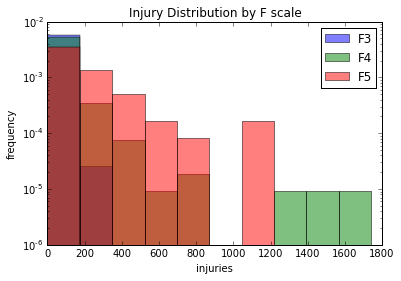

In [7]:
maxinj = np.max(torndatasel['inj'].values)
for f in [3,4,5]:
    plt.hist(torndatasel[(torndatasel['f'] == f)]['inj'].values, log=True, label='F'+str(f), alpha=0.5, range=(0,maxinj), normed=True)
plt.xlabel('injuries')
plt.ylabel('frequency')
plt.title('Injury Distribution by F scale')
plt.legend()
plt.show()

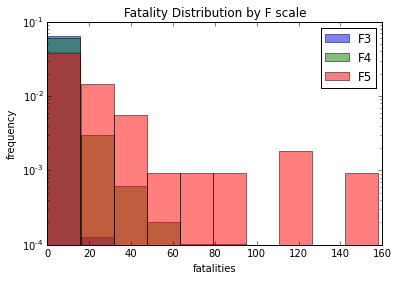

In [8]:
maxinj = np.max(torndatasel['fat'].values)
for f in [3,4,5]:
    plt.hist(torndatasel[(torndatasel['f'] == f)]['fat'].values, log=True, label='F'+str(f), alpha=0.5, range=(0,maxinj), normed=True)
plt.xlabel('fatalities')
plt.ylabel('frequency')
plt.title('Fatality Distribution by F scale')
plt.legend()
plt.show()

Effective population density also turns out to be a good predictor of tornado injuries and fatalities. The distributions are again peaked around zero, possibly because counties typically have a large amount of sparsely populated land and a small amount of densely populated land. And again, the injury distribution for tornadoes in more dense counties have tails that extend to higher numbers. The fatality distribution is similar.

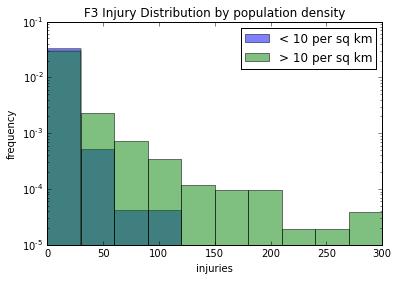

In [9]:
maxinj = np.max(torndatasel[torndatasel['f'] == 3]['inj'].values)
plt.hist(torndatasel[(torndatasel['pop_dens'] < 1e-5) & (torndatasel['f'] == 3)]['inj'].values, log=True, label='< 10 per sq km', alpha=0.5, range=(0,maxinj), normed=True)
plt.hist(torndatasel[(torndatasel['pop_dens'] > 1e-5) & (torndatasel['f'] == 3)]['inj'].values, log=True, label='> 10 per sq km', alpha=0.5, range=(0,maxinj), normed=True)
plt.xlabel('injuries')
plt.ylabel('frequency')
plt.title('F3 Injury Distribution by population density')
plt.legend()
plt.show()

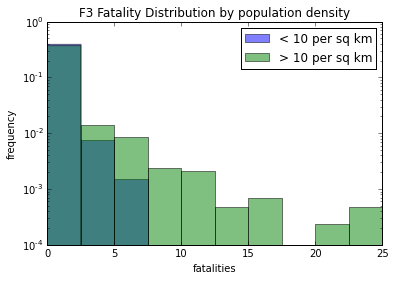

In [10]:
maxinj = np.max(torndatasel[torndatasel['f'] == 3]['fat'].values)
plt.hist(torndatasel[(torndatasel['pop_dens'] < 1e-5) & (torndatasel['f'] == 3)]['fat'].values, log=True, label='< 10 per sq km', alpha=0.5, range=(0,maxinj), normed=True)
plt.hist(torndatasel[(torndatasel['pop_dens'] > 1e-5) & (torndatasel['f'] == 3)]['fat'].values, log=True, label='> 10 per sq km', alpha=0.5, range=(0,maxinj), normed=True)
plt.xlabel('fatalities')
plt.ylabel('frequency')
plt.title('F3 Fatality Distribution by population density')
plt.legend()
plt.show()

We have tornado warning data from 1986 onwards and so can investigate the effects of tornado warnings. Some warnings are issued after tornado touchdown - these we call delayed warnings. Warnings issued before touchdown we term advanced. There is no obvious difference between tornadoes with no warnings and tornadoes with delayed or advanced warnings. Still, we will include advanced warnings in our model to see if we can detect any effects.

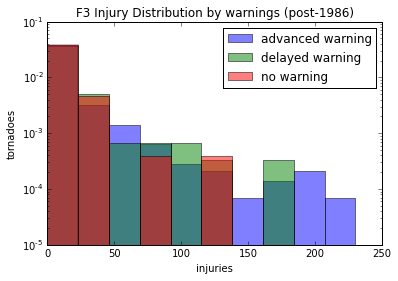

In [11]:
plt.title('F3 Injury Distribution by warnings (post-1986)')
maxinj = np.max(torndatasel[(torndatasel['f'] == 3) & (torndatasel['yr'] >= 1986)]['inj'].values)
plt.hist(torndatasel[(torndatasel['f'] == 3) & (torndatasel['yr'] >= 1986) & (torndatasel['has_warning'] == True) & (torndatasel['warning_time'] > 0)]['inj'].values,
          log=True, normed=True, alpha=0.5, range=(0,maxinj), label='advanced warning')
plt.hist(torndatasel[(torndatasel['f'] == 3) & (torndatasel['yr'] >= 1986) & (torndatasel['has_warning'] == True) & (torndatasel['warning_time'] < 0)]['inj'].values,
          log=True, normed=True, alpha=0.5, range=(0,maxinj), label='delayed warning')
plt.hist(torndatasel[(torndatasel['f'] == 3) & (torndatasel['yr'] >= 1986) & (torndatasel['has_warning'] == False)]['inj'].values,
         log=True, normed=True, alpha=0.5, range=(0,maxinj), label='no warning')
plt.xlabel('injuries')
plt.ylabel('tornadoes')
plt.legend()
plt.show()

## Modelling
In this notebook, we include the code to run our analysis for injuries from F5 tornadoes (since F5 tornadoes are the least numerous, their analysis is the shortest to run). The code is very similar for the other F scales and for fatalities instead of injuries. In fact, we use the same Stan model, just with different inputs.

In [12]:
torndatasubsel = torndatasel[(torndatasel['f'] == 5)].copy() # select an F scale
loss = 'inj' # either injuries or losses
filename = 'injurymodelling-f5.pkl' # where to save file
torndatasubsel.head()

,om,yr,mo,dy,date,time,tz,st,stf,stn,f,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,ns,sn,sg,f1,f2,f3,f4,touchdown,has_warning,has_watch,warning_time,pop_dens
890,162,1953,5,11,1953-05-11,16:10:00,3,TX,48,9,5,597,114,7,0,31.55,-97.15,31.75,-96.88,20.9,583,1,1,1,309,0,0,0,1953-05-11 22:10:00,False,False,0,0.000048
930,201,1953,5,29,1953-05-29,17:00:00,3,ND,38,2,5,20,2,5,0,46.45,-100.67,46.63,-100.47,14.8,600,1,1,1,59,29,0,0,1953-05-29 23:00:00,False,False,0,0.000003
1006,275,1953,6,8,1953-06-08,19:30:00,3,MI,26,10,5,844,116,7,0,43.10,-83.85,43.17,-83.42,18.9,833,1,1,1,49,87,0,0,1953-06-09 01:30:00,False,False,0,0.000093
1048,318,1953,6,27,1953-06-27,15:45:00,3,IA,19,20,5,2,1,5,0,41.45,-94.70,0.00,0.00,0.1,100,1,1,1,1,0,0,0,1953-06-27 21:45:00,False,False,0,0.000008
1147,416,1953,12,5,1953-12-05,17:45:00,3,MS,28,21,5,270,38,7,0,32.33,-90.90,32.42,-90.78,9.0,500,1,1,1,149,0,0,0,1953-12-05 23:45:00,False,False,0,0.000026


Here we prepare indicator variables for advanced warnings, and the states and years of each tornado.

In [13]:
earlywarning = (torndatasubsel['has_warning']) & (torndatasubsel['warning_time'] > 0)

In [14]:
states = torndatasubsel['st'].unique()
tornsts = np.empty((torndatasubsel.index.size, states.size), dtype=np.bool)

for i in xrange(states.size):
    tornsts[:, i] = (torndatasubsel['st'] == states[i])

In [15]:
years_used = range(1950, 2015)

tornyrs = np.empty((torndatasubsel.index.size, len(years_used)), dtype=np.bool)
for i in xrange(len(years_used)):
    tornyrs[:,i] = (torndatasubsel['yr'] == years_used[i])

We separately model each F scale and separately model injuries and fatalities. Similar to our frequency model, we use a hierarchical linear regression on the logarithm of the expected injuries (or fatalities). This regression naturally ensures that the expected number of injuries is positive, and treats all effects as multiplicative. The constant factor captures the average injuries expected from a tornado of this F scale, independent of location and year. We assume tornado injuries scale with a power law of population density - injuries may not be simply proportional to population density because of the geographical clustering of human populations. We place uniform priors on this constant factor and this power law index.

We include year factors and state factors, but not county factors because we do not have injury information on a county-by-county basis. We include a noise factor for each tornado to allow for overdispersion. The year, state, and noise factors are assumed to be drawn from Gaussian populations whose variances are hyperparameters we fit for. These hyperparameters are given Cauchy priors.

We also include a warning factor, even though we only have warnings from 1986 onwards. Any effects from warnings before 1986 will just be absorbed into the pre-1986 year factors, and we hope to pull out post-1986 warning effects.

$$\log \lambda_{tornado} = \beta_{constant} + \beta_{populationdensity} populationdensity_{tornado} + \beta_{year=year_{tornado}} + \beta_{state=state_{tornado}} + \beta_{warning} warning_{tornado} + \beta_{noise, tornado}$$

As an additional source of overdispersion, we assume that injuries are distributed with a negative binomial distribution instead of a Poisson distribution. In the limit where the precision of the negative binomial $\phi \to 0$, it becomes a Poisson. The precision of the negative binomial is given a Cauchy distribution. Before adding this additional overdispersion, we noticed two problems. First, the noise factors were not Gaussian distributed but instead had a significant low tail. Second, the posterior predictive distribution of injuries did not agree well with the actual injury distribution. The introduction of the negative binomial solved both of these problems, as will be demonstrated later. 

<img src="Directed_Acyclic_injury.png">

In [16]:
tornado_model = """
data {
    int N_torn; // number of tornados
    int N_yr; // number of time periods
    int N_st; // number of states
    vector[N_torn] logpopdens; // effective population density for each tornado
    int y[N_torn]; // number of injuries/fatalities for each tornado
    vector[N_torn] earlywarning; // flag for whether each tornado had an early warning
    matrix[N_torn, N_yr] tornyrs; // flag indicating which year each tornado occurred in 
    matrix[N_torn, N_st] tornsts; // flag indicating which state each tornado occurred in
}
parameters {
    real<lower=0> phi; // overdispersion of negative binomial (relative to poisson)
    real const_factor; // constant factors for all tornadoes of this F-class
    real popdens_power; // power-law dependence on effective population density
    
    vector[N_torn] noise_factor; // overdispersion for each tornado
    real<lower=0> noise_hp_sig; // population variance for overdispersions
    
    real warning_factor; // factor for tornadoes with early warnings
    
    vector[N_yr] year_factor; // factor for each year
    real<lower=0> yr_hp_sig; // population variance for years
    
    vector[N_st] state_factor; // factor for each state
    real<lower=0> st_hp_sig; // population variance for states
}
transformed parameters {
    vector[N_torn] lambda; // expected number of injuries/fatalities for each tornado
    lambda <- exp(const_factor + popdens_power * logpopdens + tornsts * state_factor + warning_factor * earlywarning + tornyrs * year_factor + noise_factor);
}
model  {
    phi ~ cauchy(0, 1);
    
    y ~ neg_binomial_2(lambda, phi);
    
    noise_factor ~ normal(0, noise_hp_sig);
    noise_hp_sig ~ cauchy(0, 1);
    
    year_factor ~ normal(0, yr_hp_sig);
    yr_hp_sig ~ cauchy(0, 1);
    
    state_factor ~ normal(0, st_hp_sig);
    st_hp_sig ~ cauchy(0, 1);
}
"""

In [17]:
tornado_dat = {'N_torn':len(torndatasubsel.index),
               'N_yr': len(years_used),
               'N_st': states.size,
               'tornsts': tornsts.astype(int),
               'tornyrs': tornyrs.astype(int),
               'earlywarning': earlywarning.astype(int),
               'logpopdens': np.log(torndatasubsel['pop_dens'].values),
               'y': torndatasubsel[loss].values}

In [18]:
niter = 1000
fit = pystan.stan(model_code=tornado_model, data=tornado_dat, iter=2*niter, chains=1)
extract = fit.extract(permuted=True)

Since the longest models took hours to run, we save the chains to intermediate files to be read later.

In [19]:
f = open(filename, 'w')
pickle.dump(states.astype(list), f)
pickle.dump(extract, f)
f.close()

### F3 Tornadoes, Injuries

In this notebook, we show results for all F scales by loading in these intermediate files. We load in the tornado data for each F scale so that the posterior predictive distributions can be compared to the data.

In [20]:
torndatasel = pd.read_csv('1950-2014_torn.popdens.csv', index_col=0)
niter = 1000

In [21]:
torndatasubsel = torndatasel[torndatasel['f'] == 3].copy()

f = open('injurymodelling-f3.pkl')
states = pickle.load(f)
extract = pickle.load(f)
f.close()

earlywarning = (torndatasubsel['has_warning']) & (torndatasubsel['warning_time'] > 0)
tornsts = np.empty((torndatasubsel.index.size, states.size), dtype=np.bool)

for i in xrange(states.size):
    tornsts[:, i] = (torndatasubsel['st'] == states[i])

years_used = range(1950, 2015)

tornyrs = np.empty((torndatasubsel.index.size, len(years_used)), dtype=np.bool)
for i in xrange(len(years_used)):
    tornyrs[:,i] = (torndatasubsel['yr'] == years_used[i])

Let's look at our non-hierarchical parameters. F3 injuries appear to go with population density to the $0.47\pm0.04$ power. Warnings seem to be associated with tornadoes that cause more injuries! However, the mean warning factor is less than one sigma away from zero, so this effect may not be significant. This effect may be hard to detect because after 1986 most tornadoes have advanced warnings, so there are few tornadoes without warnings to compare to. In addition, the tornadoes without warnings may be tornadoes that are harder to detect because they are on the weak side of the F3 category (closer to F2).

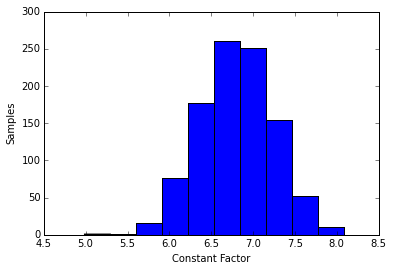

mean 6.80304645136
std dev 0.431806409898


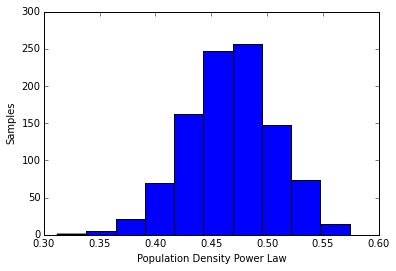

mean 0.467907137538
std dev 0.0386582492745


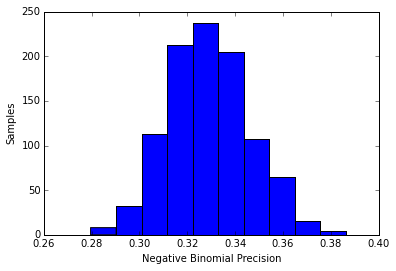

mean 0.328882074131
std dev 0.0170528975125


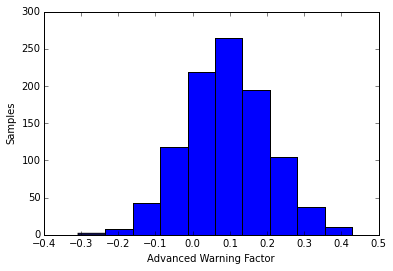

mean 0.0922234754427
std dev 0.111899446887


In [22]:
def plots1():
    labels = ['const_factor', 'popdens_power', 'phi', 'warning_factor']
    names = ['Constant Factor', 'Population Density Power Law', 'Negative Binomial Precision', 'Advanced Warning Factor']
    for i in xrange(4):
        plt.hist(extract[labels[i]])
        plt.xlabel(names[i])
        plt.ylabel('Samples')
        plt.show()
        print "mean", np.mean(extract[labels[i]])
        print "std dev", np.std(extract[labels[i]])
plots1()

We use the posterior to predict a total number of injuries from the list of tornadoes we used to fit the model. That is, wwe ask, given this list of tornadoes and their properties (population density, state, year, and warning), how many injuries does our model predict. First, go through each sample in the chain and keep all the parameters except the noise factors - these we re-generate using the noise hyperparameter. Then, using the properties of each tornado in the data, we use the negative binomial to generate ten possible injury numbers. This gives us ten possible injury realizations for each sample. We histogram the total injury number in all these realizations and compare to the total number of injuries in the data, finding good agreement.

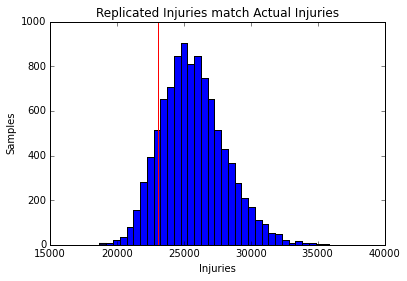

In [23]:
def plots2(loss):
    injuryhist = []
    for i in xrange(niter):
        for j in xrange(10):
            noise_factor = np.random.normal(scale=extract['noise_hp_sig'][i], size=torndatasubsel.index.size)
            lambdas = np.exp(extract['popdens_power'][i]*np.log(torndatasubsel['pop_dens'].values) + np.dot(earlywarning, extract['warning_factor'][i]) +
                             np.dot(tornsts, extract['state_factor'][i]) + np.dot(tornyrs, extract['year_factor'][i]) + extract['const_factor'][i] + noise_factor)
            phi = extract['phi'][i]
            injuries = np.sum(stats.nbinom.rvs(phi, phi/(lambdas+phi)))
            injuryhist.append(injuries)
    totalinjuries = np.sum(torndatasubsel[loss].values)
    plt.hist(injuryhist, bins=40)
    plt.axvline(totalinjuries, color='r')
    if loss == 'inj':
        plt.title('Replicated Injuries match Actual Injuries')
        plt.xlabel('Injuries')
    if loss == 'fat':
        plt.title('Replicated Fatalities match Actual Fatalities')
        plt.xlabel('Fatalities')
    plt.ylabel('Samples')
    plt.show()
plots2('inj')

We pick four random samples from the chain, and look at the distribution of noise factors for each tornado. These noise parameters are indeed normally distributed, suggesting that our model is adequately fitting the data.

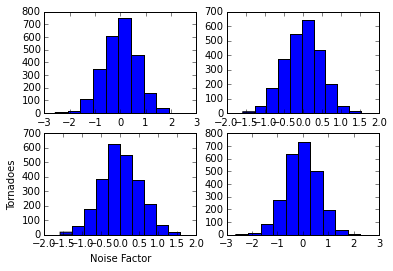

In [24]:
def plots3():
    for sp in [221, 222, 223, 224]:
        plt.subplot(sp)
        plt.hist(extract['noise_factor'][np.random.randint(1000)])
        if sp == 223:
            plt.xlabel('Noise Factor')
            plt.ylabel('Tornadoes')
    plt.show()
plots3()

We also pick a random sample from the chain and generate injury numbers for each tornado in the data, using a similar procedure as above. We then compare the distribution of these replicated injury numbers with the distribution of the data injury numbers.

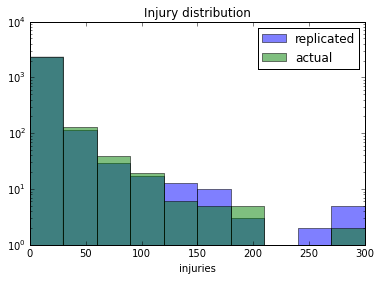

In [25]:
def plots4(loss):
    maxinj = np.max(torndatasubsel[loss].values)
    i = np.random.randint(niter)
    noise_factor = np.random.normal(scale=extract['noise_hp_sig'][i], size=torndatasubsel.index.size)
    lambdas = np.exp(extract['popdens_power'][i]*np.log(torndatasubsel['pop_dens'].values) + np.dot(earlywarning, extract['warning_factor'][i]) +
                     np.dot(tornsts, extract['state_factor'][i]) + np.dot(tornyrs, extract['year_factor'][i]) + extract['const_factor'][i] + noise_factor)
    phi = extract['phi'][i]
    injuries = stats.nbinom.rvs(phi, phi/(lambdas+phi))
    plt.hist(injuries, log=True, alpha=0.5, range=(0,maxinj), label='replicated')
    plt.hist(torndatasubsel[loss].values, log=True, alpha=0.5, range=(0,maxinj), label='actual')
    plt.legend()
    if loss == 'inj':
        plt.xlabel('injuries')
        plt.title('Injury distribution')
    if loss == 'fat':
        plt.xlabel('fatalities')
        plt.title('Fatality distribution')
    plt.show()
plots4('inj')

The year factors seem to all be consistent with zero, which is somewhat surprising given the improvements in forecasts and warnings since the 1950s.

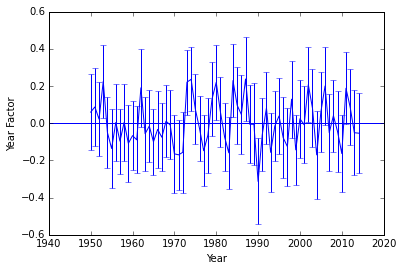

In [26]:
def plots5():
    plt.errorbar(np.arange(1950, 2015), np.mean(extract['year_factor'], axis=0), np.std(extract['year_factor'], axis=0))
    plt.axhline(0)
    plt.xlim((1940, 2020))
    plt.xlabel('Year')
    plt.ylabel('Year Factor')
    plt.show()
plots5()

Many of the state factors are consistent with zero, which makes sense. Tornadoes that touch down in different states but in similar conditions (same year and population density) should cause similar numbers of injuries. There are some states with state factors significantly different from zero. This might be because of trends in home construction across states - some states have more mobile homes which are unsafe in tornadoes, other states may have more homes with basements or emergency shelters. (In these maps, states with higher state factors are darker.)

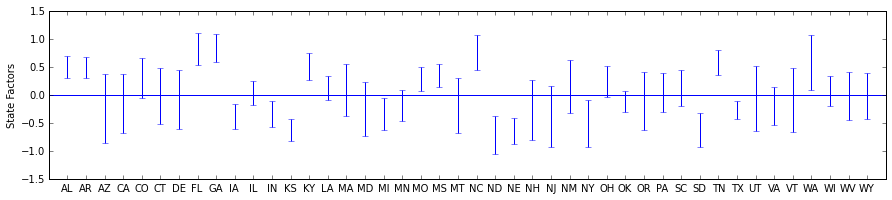

In [27]:
def plots6():
    plt.figure(figsize=(15,3))
    plt.errorbar(range(states.size), np.mean(extract['state_factor'], axis=0)[np.argsort(states)], np.std(extract['state_factor'], axis=0)[np.argsort(states)], fmt='none')
    plt.axhline(0)
    plt.xticks(range(states.size), states[np.argsort(states)])
    plt.xlim((-1, states.size))
    plt.ylabel('State Factors')
    plt.show()

    state_map = us.states.mapping('abbr', 'name')

    sf_df = pd.DataFrame(data=[[state_map[states[i]], np.mean(extract['state_factor'], axis=0)[i]] for i in xrange(states.size)])
    sf_df.columns = ['State Name', 'State Factor']


    geo_data = [{'name': 'states', 'url': 'us_states.topo.json', 'feature': 'us_states.geo'}]
    vis = vincent.Map(data=sf_df, geo_data=geo_data, scale=1000, projection='albersUsa', data_bind='State Factor', data_key='State Name', map_key={'states': 'properties.NAME'})
    vis.display()
plots6()

### F3 Tornadoes, Fatalities

Fatalties are not just a constant fraction of injuries, they follow a different power of population density than injuries: $0.24\pm0.05$. Warnings seem to be associated with tornadoes that cause more fatalities, at the 2 sigma level.

The posterior predictive distributions still pass our model checks. Most of the year factors are consistent with zero, and the state factors look similar to those for injuries.

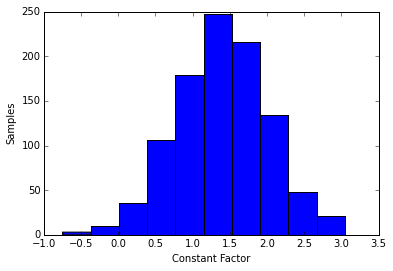

mean 1.39779826586
std dev 0.602388710443


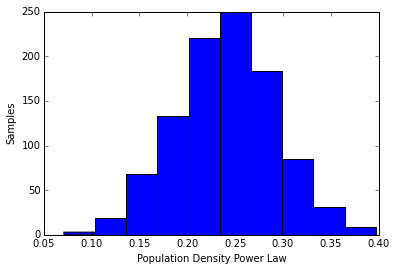

mean 0.240131634179
std dev 0.0520927988329


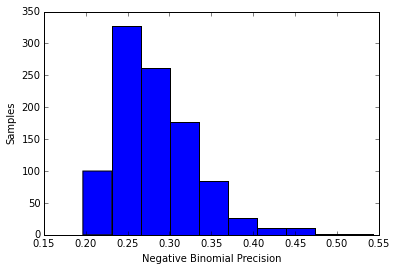

mean 0.283859787577
std dev 0.0486488473854


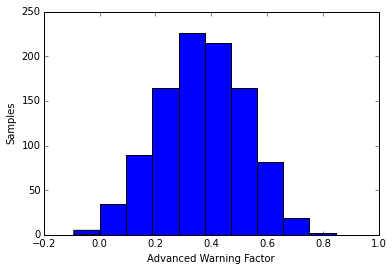

mean 0.367456873671
std dev 0.152676622472


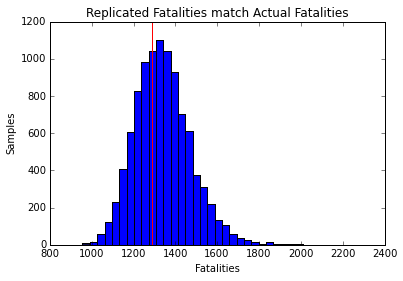

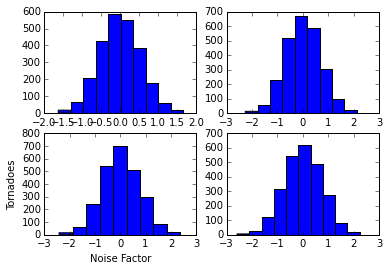

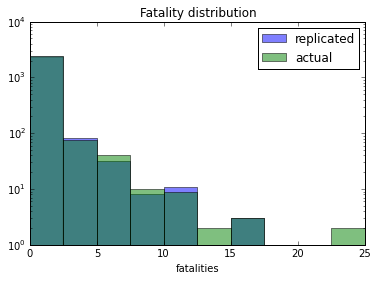

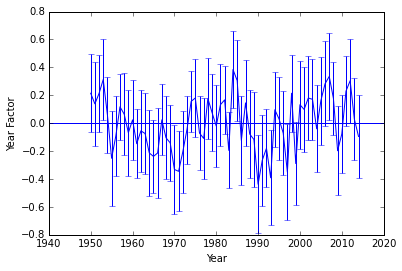

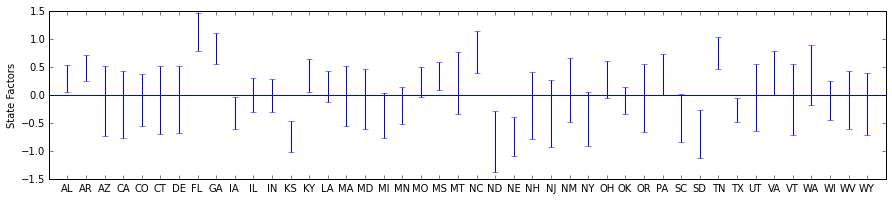

In [28]:
torndatasubsel = torndatasel[torndatasel['f'] == 3].copy()

f = open('injurymodelling-f3-fat.pkl')
states = pickle.load(f)
extract = pickle.load(f)
f.close()

earlywarning = (torndatasubsel['has_warning']) & (torndatasubsel['warning_time'] > 0)

tornsts = np.empty((torndatasubsel.index.size, states.size), dtype=np.bool)
for i in xrange(states.size):
    tornsts[:, i] = (torndatasubsel['st'] == states[i])

tornyrs = np.empty((torndatasubsel.index.size, len(years_used)), dtype=np.bool)
for i in xrange(len(years_used)):
    tornyrs[:,i] = (torndatasubsel['yr'] == years_used[i])

def allplots(loss):
    plots1()
    plots2(loss)
    plots3()
    plots4(loss)
    plots5()
    plots6()

allplots('fat')

### F4 Tornadoes, Injuries
As expected, the constant factor for F4 tornadoes is higher than for F3 tornadoes: $9.8\pm0.8$ for F4 vs $6.8\pm0.4$ for F3. F4 tornado injuries appear to follow a similar power law to F3 tornado injuries: $0.58\pm0.07$.

At the two sigma level, warnings seem to decrease injuries for F4 tornadoes.

Again, the model checks look good and the year factors are consistent with zeros. The error bars on the state factors are larger, making the state factors less significant.

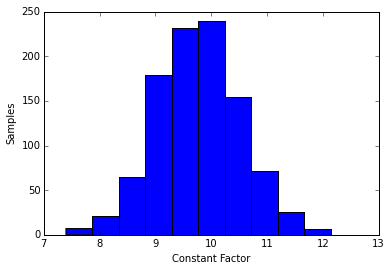

mean 9.7695157946
std dev 0.745861895541


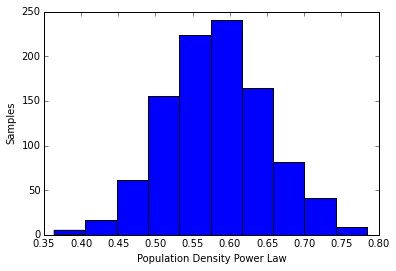

mean 0.581022759796
std dev 0.0681939874922


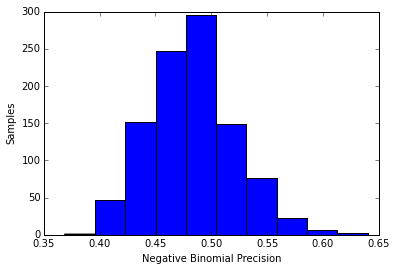

mean 0.483318249532
std dev 0.0384380628517


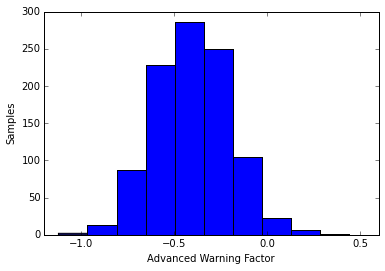

mean -0.402230735932
std dev 0.200007907382


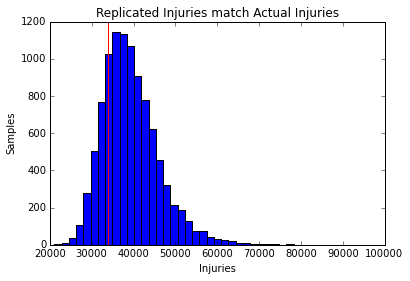

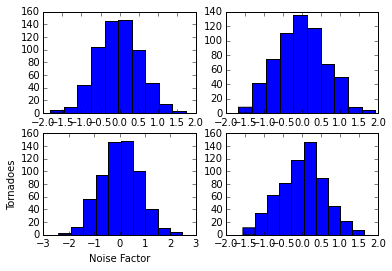

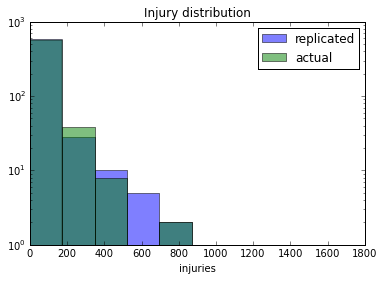

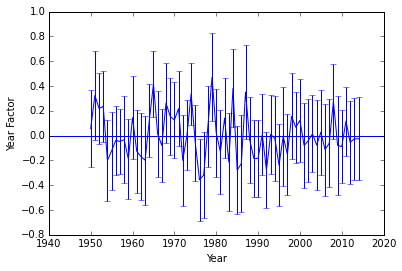

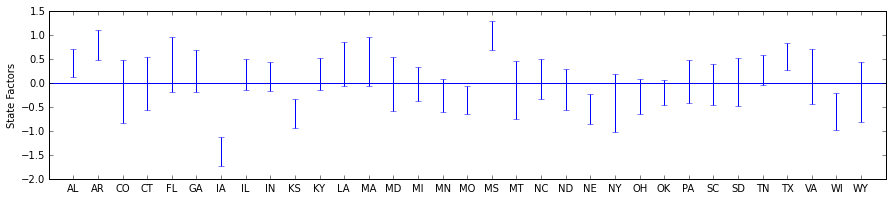

In [29]:
torndatasubsel = torndatasel[torndatasel['f'] == 4].copy()

f = open('injurymodelling-f4.pkl')
states = pickle.load(f)
extract = pickle.load(f)
f.close()

earlywarning = (torndatasubsel['has_warning']) & (torndatasubsel['warning_time'] > 0)

tornsts = np.empty((torndatasubsel.index.size, states.size), dtype=np.bool)
for i in xrange(states.size):
    tornsts[:, i] = (torndatasubsel['st'] == states[i])

tornyrs = np.empty((torndatasubsel.index.size, len(years_used)), dtype=np.bool)
for i in xrange(len(years_used)):
    tornyrs[:,i] = (torndatasubsel['yr'] == years_used[i])

allplots('inj')

### F4 Tornadoes, Fatalities
As expected, the constant factor for F4 tornadoes is higher than for F3 tornadoes: $3.4\pm0.7$ for F4 vs $1.4\pm0.6$ for F3. F4 tornado injuries appear to follow a similar power law to F3 tornado injuries: $0.23\pm0.06$.

At the one sigma level, warnings seem to decrease fatalities for F4 tornadoes.

Again, the model checks look good and the year factors are consistent with zeros. The error bars on the state factors are larger, making the state factors less significant. The state factors are similar to those for F4 injuries.

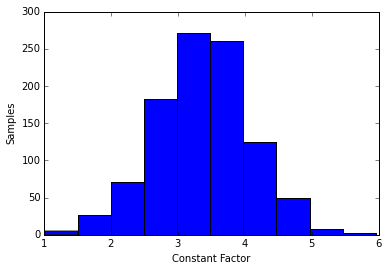

mean 3.37511648768
std dev 0.705725751712


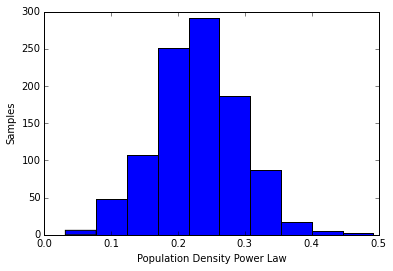

mean 0.230163270273
std dev 0.0640129730915


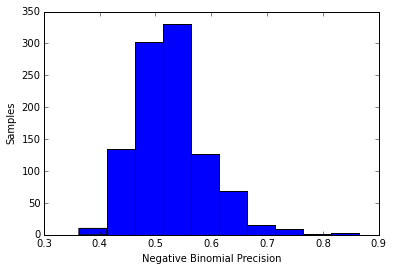

mean 0.525643523657
std dev 0.0633094738451


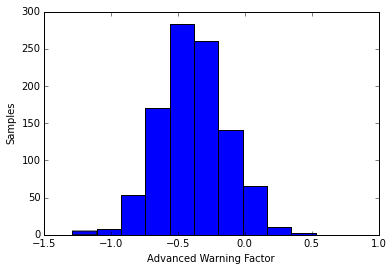

mean -0.382592400609
std dev 0.248548663091


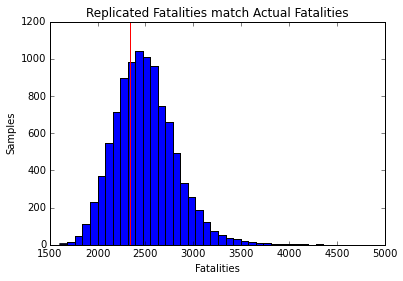

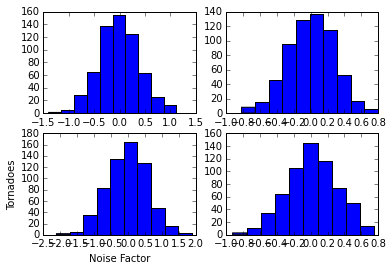

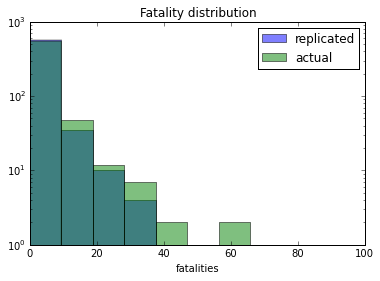

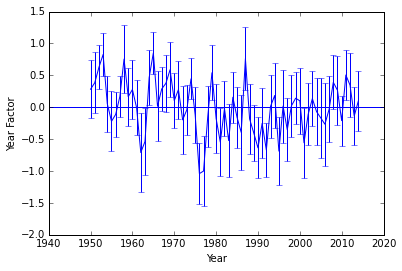

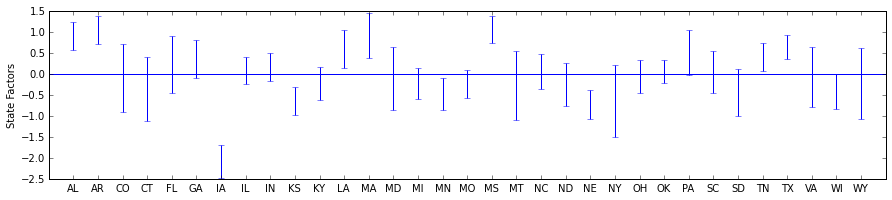

In [30]:
torndatasubsel = torndatasel[torndatasel['f'] == 4].copy()

f = open('injurymodelling-f4-fat.pkl')
states = pickle.load(f)
extract = pickle.load(f)
f.close()

earlywarning = (torndatasubsel['has_warning']) & (torndatasubsel['warning_time'] > 0)

tornsts = np.empty((torndatasubsel.index.size, states.size), dtype=np.bool)
for i in xrange(states.size):
    tornsts[:, i] = (torndatasubsel['st'] == states[i])

tornyrs = np.empty((torndatasubsel.index.size, len(years_used)), dtype=np.bool)
for i in xrange(len(years_used)):
    tornyrs[:,i] = (torndatasubsel['yr'] == years_used[i])

allplots('fat')

### F5 Tornadoes, Injuries
The constant factor for 5 tornadoes is higher than for F4 tornadoes: $11.3\pm1.8$ for F5 vs $9.8\pm0.8$ for F4. F5 tornado injuries appear to follow a similar power law to F3-4 tornado injuries: $0.59\pm0.17$.

Again, the model checks look good, although it is harder to tell now that we are looking at so few tornadoes. The warning factor is consistent with zero. The year and state factors are all consistent with zero.

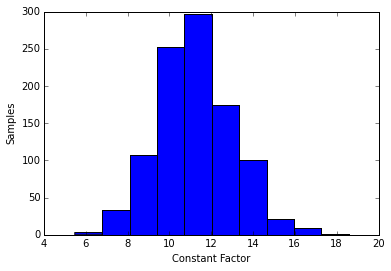

mean 11.266558831
std dev 1.81569146186


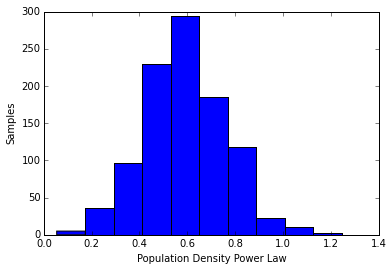

mean 0.588848417598
std dev 0.171505766437


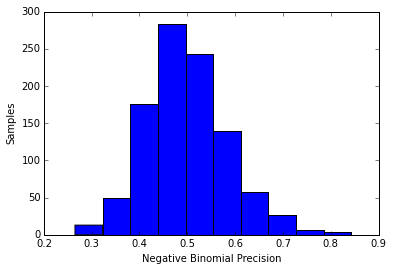

mean 0.499272829536
std dev 0.0850181077533


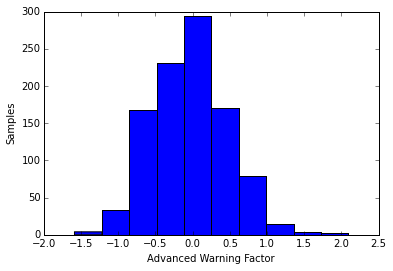

mean -0.0326395763005
std dev 0.498926894193


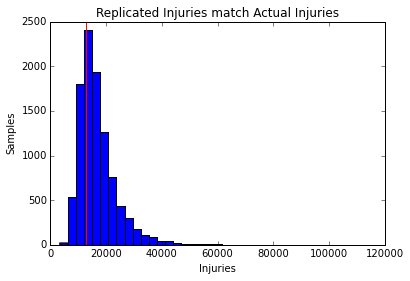

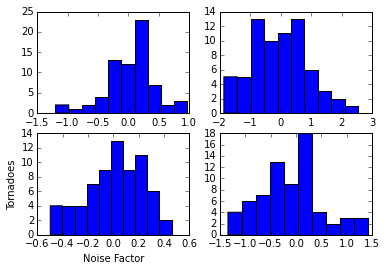

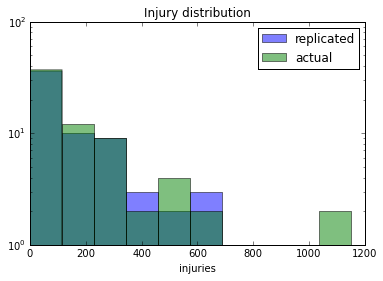

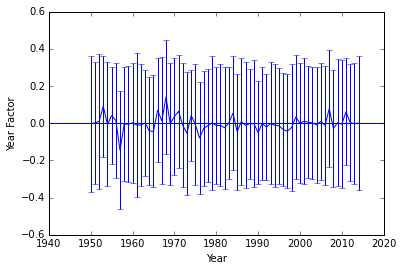

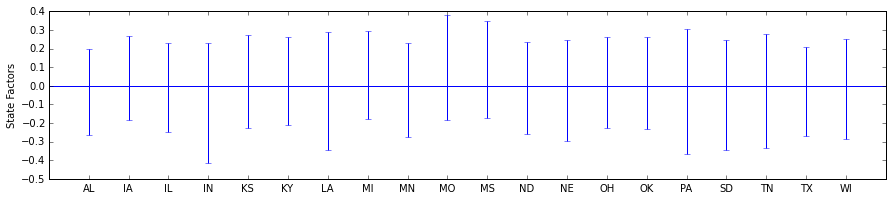

In [31]:
torndatasubsel = torndatasel[torndatasel['f'] == 5].copy()

f = open('injurymodelling-f5.pkl')
states = pickle.load(f)
extract = pickle.load(f)
f.close()

earlywarning = (torndatasubsel['has_warning']) & (torndatasubsel['warning_time'] > 0)

tornsts = np.empty((torndatasubsel.index.size, states.size), dtype=np.bool)
for i in xrange(states.size):
    tornsts[:, i] = (torndatasubsel['st'] == states[i])

tornyrs = np.empty((torndatasubsel.index.size, len(years_used)), dtype=np.bool)
for i in xrange(len(years_used)):
    tornyrs[:,i] = (torndatasubsel['yr'] == years_used[i])

allplots('inj')

### F5 Tornadoes, Fatalities
The constant factor for F5 tornadoes is higher than for F4 tornadoes: $8.3\pm2.1$ for F4 vs $3.4\pm0.7$ for F4. Oddly, F5 tornado fatalities appear to follow a similar power law to F3-5 tornado fatalities: $0.57\pm0.19$. However, this power law has very large error bars.

Again, the model checks look good, although it is harder to tell now that we are looking at so few tornadoes. The warning factor is consistent with zero. The year and state factors are all consistent with zero.

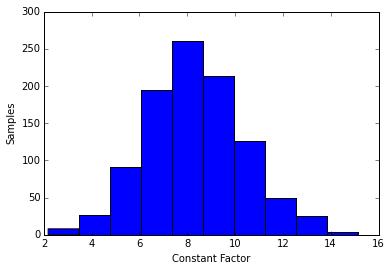

mean 8.32785002102
std dev 2.05671097096


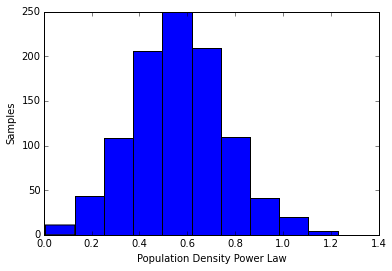

mean 0.565005514222
std dev 0.19372360692


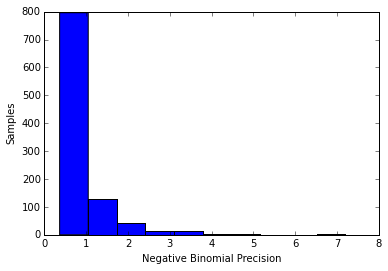

mean 0.946922902356
std dev 0.672613527644


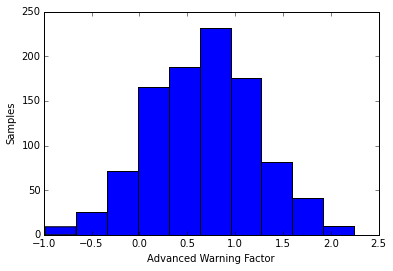

mean 0.672785117971
std dev 0.555628884922


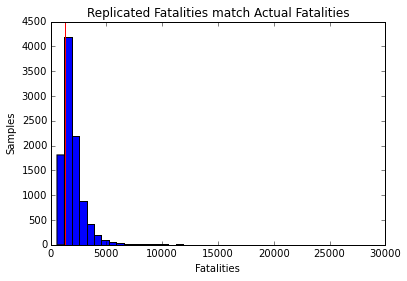

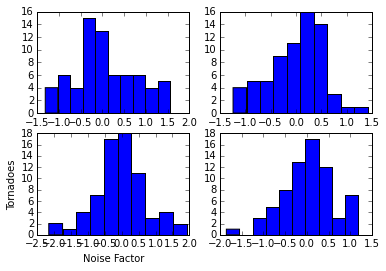

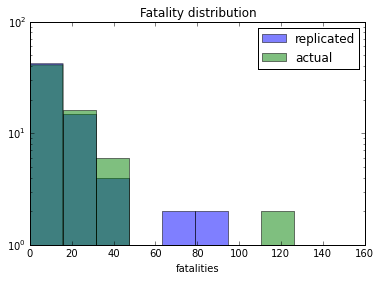

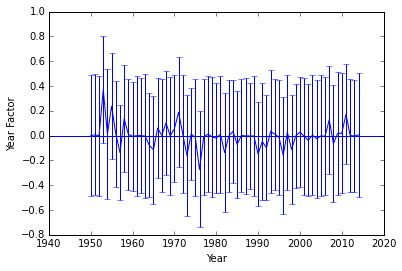

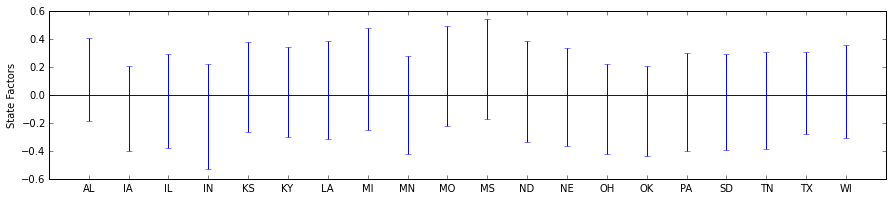

In [32]:
torndatasubsel = torndatasel[torndatasel['f'] == 5].copy()

f = open('injurymodelling-f5-fat.pkl')
states = pickle.load(f)
extract = pickle.load(f)
f.close()

earlywarning = (torndatasubsel['has_warning']) & (torndatasubsel['warning_time'] > 0)

tornsts = np.empty((torndatasubsel.index.size, states.size), dtype=np.bool)
for i in xrange(states.size):
    tornsts[:, i] = (torndatasubsel['st'] == states[i])

tornyrs = np.empty((torndatasubsel.index.size, len(years_used)), dtype=np.bool)
for i in xrange(len(years_used)):
    tornyrs[:,i] = (torndatasubsel['yr'] == years_used[i])

allplots('fat')